# Model validation water levels

Note: this notebook requires the model output data

In [1]:
import mikeio
import modelskill as ms
import matplotlib.pyplot as plt 
import helper as h
import pandas as pd

In [2]:
ms.options.metrics.list = ["rmse", "mae", "cc", "si", "r2"]

Instead of reading the entire dfsu (`Area.dfsu`), we can simply load the outputted points (dfs0) since they correspond to the locations we have observations from.

In [3]:
mr_fldr = "../output/"    
# mr_fldr = "../output_sample/"     # use this if you have not downloaded the full data from Zenodo yet
save_png = "sample" not in mr_fldr 
fig_fldr = "../figures/" 

In [4]:
obs_fldr = "../observations/" 
df_stn = pd.read_csv(obs_fldr + "stations.csv", index_col=0)

Model results data are stored in a dfs0 file. We can use [MIKE IO](https://dhi.github.io/mikeio) read the data to a MIKE IO Dataset.

Note: The first two spin-up days are excluded.

In [5]:
ds = mikeio.read(f"{mr_fldr}Points.dfs0", items="*Surf*", time = slice("2014-01-03", None))
ds.items

[Holyrood Bay: Surface elevation <Surface Elevation> (meter)]

## Compare to water level station observations

The [ModelSkill package](https://dhi.github.io/modelskill/) can be used to compare model results with observations.

In [6]:
wllist = h.get_wl_point_obs()

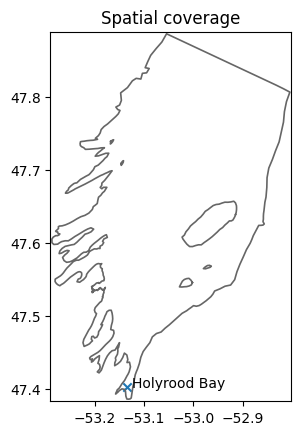

In [7]:
msh = mikeio.open("../input/ConceptionBay_mesh.mesh")
ms.plotting.spatial_overview(wllist, mod=msh);

Match the right model result timeseries and observation. Also, remove the bias (different vertical datum).

In [8]:
cmps = []
for o in wllist:
    mr = ms.PointModelResult(ds[o.name+": Surface elevation"], name="MIKE21",x=df_stn.loc[o.name].Longitude, y=df_stn.loc[o.name].Latitude)
    try:
        cmp = ms.match(obs=o, mod=mr)
    except Exception as e:
        print(e)
    cmps.append(cmp.remove_bias())
cc = ms.ComparerCollection(cmps)

## Skill table

In [9]:
cc.skill().round(3)

,n,rmse,mae,cc,si,r2
observation,,,,,,
Holyrood Bay,84510,0.112,0.088,0.936,0.427,0.876


We can see from the skill table that the model has an RMSE of 6.5-9.7 cm. 

## Timeseries

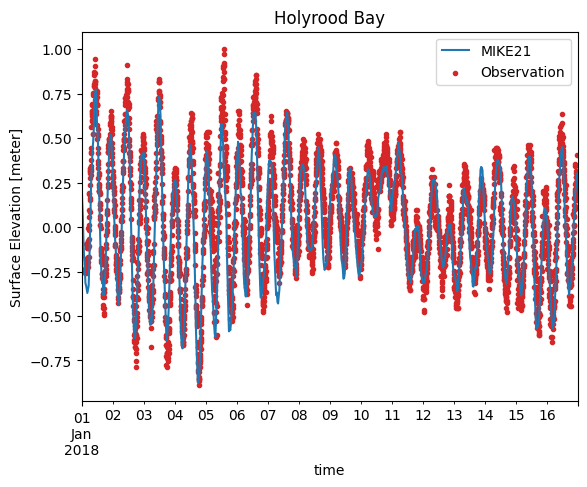

In [10]:
cc["Holyrood Bay"].sel(time=slice("2018-01-01","2018-01-16")).plot.timeseries();

## Scatter plots

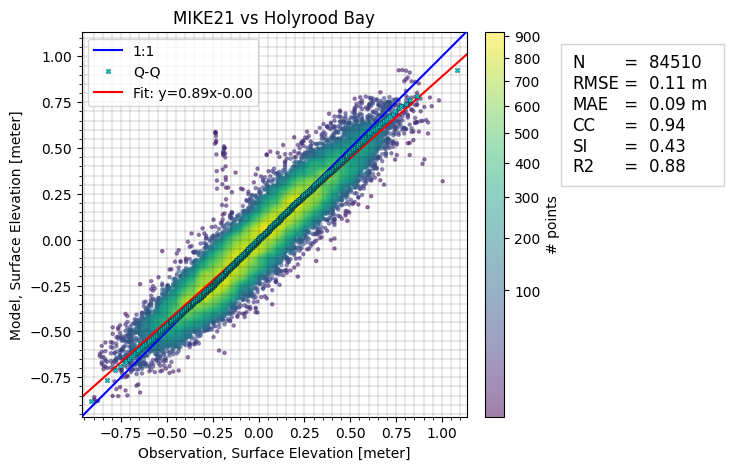

In [11]:
n_points_shown = 20000
for cmp in cc:
    cmp.plot.scatter(skill_table=True, show_points=n_points_shown, figsize=(6,5), bins=40);
    if save_png:
        plt.savefig(f"{fig_fldr}modelskill_comparison_{cmp.name}.png", bbox_inches='tight');